# Workspace Preparation

Global seed

In [2]:
SEED = 42

Import packages

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

Import data

In [4]:
dir = Path('./data/')

data = {}

for file in dir.iterdir():
    filename = file.name.removesuffix('.csv')
    df = pd.read_csv(file)
    data[filename] = df

# Preprocessing

In [5]:
def data_x_columns(data):
	columns = set([col for df in data.values() for col in df])
	columns = sorted(columns)
	mat = [[col in df for col in columns] for df in data.values()]
	df = pd.DataFrame(mat, columns=columns, index=data.keys())
	return df

Drop empty (unnamed) columns

In [6]:
unnamed = ['Unnamed: 20','Unnamed: 3','Unnamed: 30','Unnamed: 4','Unnamed: 66']
for col in unnamed:
	for df in data.values():
		if col in df:
			df.drop(columns=col, inplace=True)

Column names 'CountryCode' and 'SeriesCode' are inconsistent. Rename everywhere.

In [7]:
def rename(data, dic):
    dxc = data_x_columns(data)
    for old, new in zip(dic.keys(), dic.values()):
        if old not in dxc:
            continue
        dfs = dxc[dxc[old]].index
        for df in dfs:
            data[df].rename(columns={old: new}, inplace=True)
    return data

In [8]:
rename(data, {'CountryCode': 'Country Code',\
              'SeriesCode': 'Series Code'})
None

Indicator Codes are Series Codes for ESGData, suspectedly.

In [9]:
data['ESGData']['Indicator Code'].isin(data['ESGSeries']['Series Code']).all()

True

Rename to match.

In [10]:
data['ESGData'].rename(columns={'Indicator Code': 'Series Code'}, inplace=True)

Column names fixed.

In [11]:
temp = data_x_columns(data).T
temp[temp.sum(axis=1) > 1]

,ESGCountry-Series,ESGCountry,ESGData,ESGFootNote,ESGSeries-Time,ESGSeries
Country Code,True,True,True,True,False,False
DESCRIPTION,True,False,False,True,True,False
Indicator Name,False,False,True,False,False,True
Series Code,True,False,True,True,True,True
Year,False,False,False,True,True,False


Check the keys of the relations.

In [12]:
def check_key(df, key):
    return df.set_index(key).index.is_unique

check_key(data['ESGCountry'], ['Country Code']) and\
check_key(data['ESGCountry-Series'], ['Country Code', 'Series Code']) and\
check_key(data['ESGData'], ['Country Code','Series Code']) and\
check_key(data['ESGFootNote'], ['Country Code', 'Series Code', 'Year']) and\
check_key(data['ESGSeries'], ['Series Code']) and\
check_key(data['ESGSeries-Time'], ['Series Code', 'Year'])

True

Set indices to respective keys.

In [13]:
data['ESGCountry'].set_index('Country Code', inplace=True)
data['ESGCountry-Series'].set_index(['Country Code', 'Series Code'], inplace=True)
data['ESGData'].set_index(['Country Code','Series Code'], inplace=True)
data['ESGFootNote'].set_index(['Country Code', 'Series Code', 'Year'], inplace=True)
data['ESGSeries'].set_index('Series Code', inplace=True)
data['ESGSeries-Time'].set_index(['Series Code', 'Year'], inplace=True)
None

Store main data in variables for ease of use.

In [14]:
ESGData = data['ESGData']
ESGCountry = data['ESGCountry']
ESGSeries = data['ESGSeries']

Turn focus to ESGData to finalize.

Drop empty columns. Do not drop empty rows.

In [15]:
ESGData.drop(columns=['Country Name','Indicator Name'], inplace=True)\
		# .dropna(how='all')

Turn column names (years) into ints.

In [16]:
ESGData.columns = ESGData.columns.astype(int)

In [17]:
ESGData.head()

1960       1961       1962       1963  \
Country Code Series Code                                                
ARB          EG.CFT.ACCS.ZS      NaN        NaN        NaN        NaN   
             EG.ELC.ACCS.ZS      NaN        NaN        NaN        NaN   
             NY.ADJ.DRES.GN.ZS   NaN        NaN        NaN        NaN   
             NY.ADJ.DFOR.GN.ZS   NaN        NaN        NaN        NaN   
             AG.LND.AGRI.ZS      NaN  27.835643  27.826564  27.845522   

                                     1964       1965       1966       1967  \
Country Code Series Code                                                     
ARB          EG.CFT.ACCS.ZS           NaN        NaN        NaN        NaN   
             EG.ELC.ACCS.ZS           NaN        NaN        NaN        NaN   
             NY.ADJ.DRES.GN.ZS        NaN        NaN        NaN        NaN   
             NY.ADJ.DFOR.GN.ZS        NaN        NaN        NaN        NaN   
             AG.LND.AGRI.ZS     27.847925  27.866972  27.866171  27.918594   

                                     1968       1969  ...       2012  \
Country Code Series Code                              ...              
ARB          EG.CFT.ACCS.ZS           NaN        NaN  ...  83.120303   
             EG.ELC.ACCS.ZS           NaN        NaN  ...  87.512260   
             NY.ADJ.DRES.GN.ZS        NaN        NaN  ...  12.850205   
             NY.ADJ.DFOR.GN.ZS        NaN        NaN  ...   0.061942   
             AG.LND.AGRI.ZS     27.945029  28.003326  ...  36.472300   

                                     2013       2014       2015       2016  \
Country Code Series Code                                                     
ARB          EG.CFT.ACCS.ZS     83.533457  83.897596  84.171599  84.510171   
             EG.ELC.ACCS.ZS     88.129881  87.275323  88.720097  89.308602   
             NY.ADJ.DRES.GN.ZS  11.641062  10.437876   6.277652   5.261868   
             NY.ADJ.DFOR.GN.ZS   0.055593   0.079402   0.086177   0.076670   
             AG.LND.AGRI.ZS     36.534503  36.607475  36.624759  36.610850   

                                     2017       2018  2019  2020  2050  
Country Code Series Code                                                
ARB          EG.CFT.ACCS.ZS           NaN        NaN   NaN   NaN   NaN  
             EG.ELC.ACCS.ZS     90.283638  89.286856   NaN   NaN   NaN  
             NY.ADJ.DRES.GN.ZS   6.385551   8.190277   NaN   NaN   NaN  
             NY.ADJ.DFOR.GN.ZS   0.085885   0.047916   NaN   NaN   NaN  
             AG.LND.AGRI.ZS           NaN        NaN   NaN   NaN   NaN  

[5 rows x 62 columns]

Preprocessing is done.

# Exploratory analysis

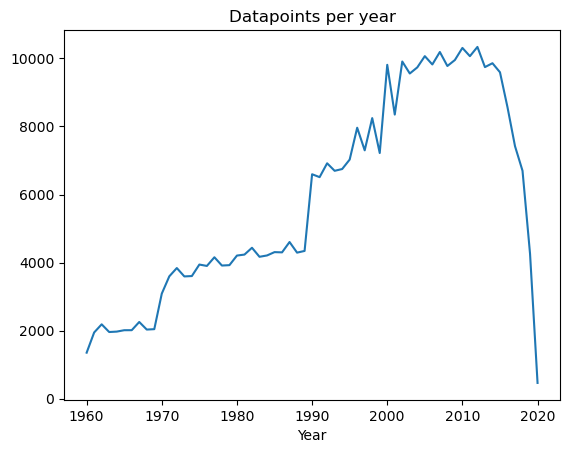

In [18]:
plt.plot(ESGData.count()[:-1])
plt.title('Datapoints per year')
plt.xlabel('Year')
None

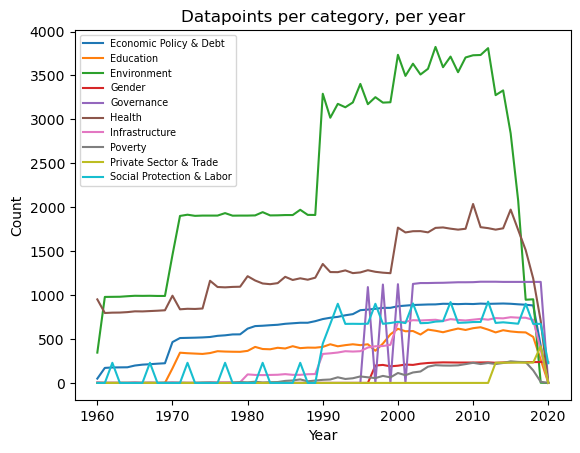

In [19]:
cat_counts = ESGData.groupby(lambda x: ESGSeries.loc[x[1],'Topic'].split(':')[0])\
					.count()
plt.plot(cat_counts.T[:-1])
plt.title('Datapoints per category, per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(cat_counts.index, fontsize='x-small')
None

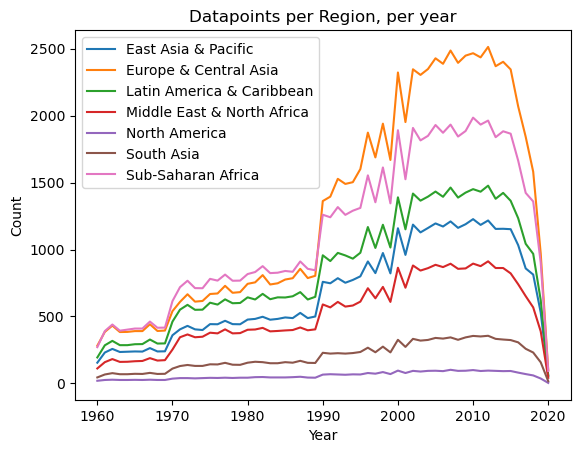

In [20]:
reg_counts = ESGData.groupby(lambda x: ESGCountry.loc[x[0],'Region'])\
					.count()
plt.plot(reg_counts.T[:-1])
plt.title('Datapoints per Region, per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(reg_counts.index)
# plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
None

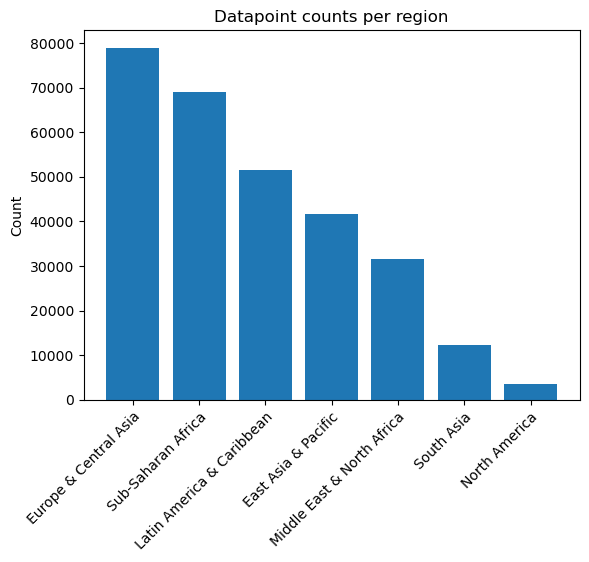

In [21]:
reg_totals = reg_counts.T.sum().sort_values(ascending=False)
plt.bar(reg_totals.index, height=reg_totals)
plt.title('Datapoint counts per region')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
None

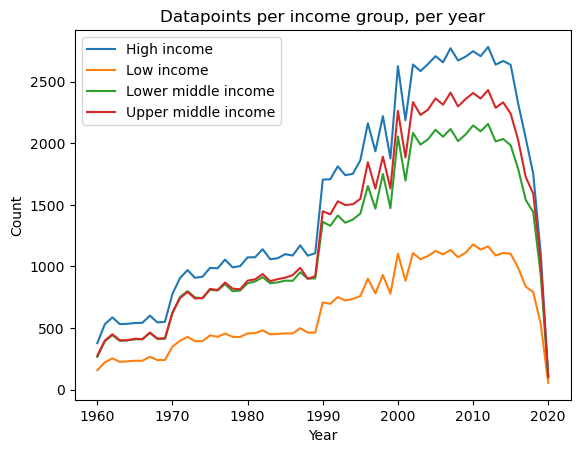

In [70]:
inc_counts = ESGData.groupby(lambda x: ESGCountry.loc[x[0],'Income Group'])\
					.count()
plt.plot(inc_counts.T[:-1])
plt.title('Datapoints per income group, per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(inc_counts.index)
None

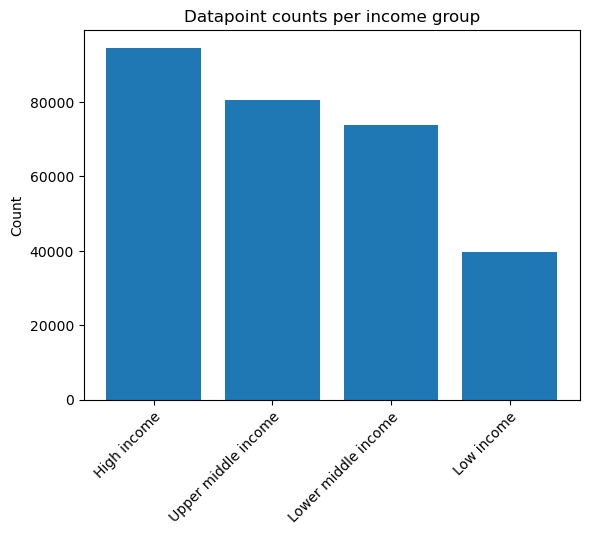

In [69]:
inc_totals = inc_counts.T.sum().sort_values(ascending=False)
plt.bar(inc_totals.index, height=inc_totals)
plt.title('Datapoint counts per income group')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
None

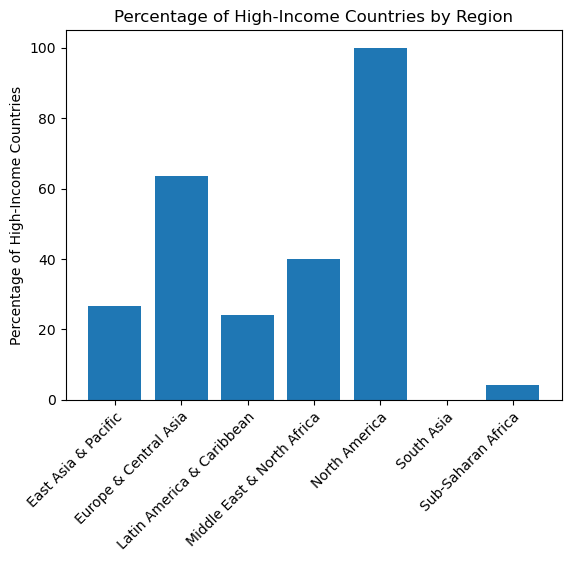

In [83]:
high_inc_reg = ESGCountry.groupby('Region')\
						 .value_counts(subset=['Income Group'], normalize=True)\
                         .unstack(level=1)\
                         ['High income'] * 100
plt.bar(high_inc_reg.index, height=high_inc_reg)
plt.title('Percentage of High-Income Countries by Region')
plt.ylabel('Percentage of High-Income Countries')
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
None

In [82]:
ESGCountry.groupby('Region')\
						 .value_counts(subset=['Income Group'], normalize=True)\
                         .unstack(level=1)['High income']\
                        #  .xs('High income', level=1)

Region
East Asia & Pacific           0.266667
Europe & Central Asia         0.634615
Latin America & Caribbean     0.242424
Middle East & North Africa    0.400000
North America                 1.000000
South Asia                         NaN
Sub-Saharan Africa            0.041667
Name: High income, dtype: float64

## Series' slopes

In [22]:
def get_slope(time, x):
    if np.isnan(x).all():
        return np.nan
    return stats.linregress(time[pd.notna(x)],x[pd.notna(x)]).slope

years = pd.Series(ESGData.columns)
slopes = ESGData.apply(lambda x: get_slope(years, x), axis=1, raw=True)\
				.dropna()

c:\Users\noelp\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\noelp\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\noelp\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [23]:
slopes.head()

Country Code  Series Code      
ARB           EG.CFT.ACCS.ZS       0.653162
              EG.ELC.ACCS.ZS       0.662557
              NY.ADJ.DRES.GN.ZS   -0.124767
              NY.ADJ.DFOR.GN.ZS   -0.000473
              AG.LND.AGRI.ZS       0.215015
dtype: float64

In [24]:
series_slopes = slopes.groupby('Series Code')\
    				  .describe()\
					  .dropna()

Add dimensionless stats to slope stats.

In [25]:
series_slopes['max_rate'] = series_slopes['max'] / series_slopes['mean'].abs()
series_slopes['max_id'] = slopes.groupby('Series Code').apply(lambda x: x.idxmax()[0])
series_slopes['CoV'] = series_slopes['std'] / series_slopes['mean'].abs() # Coefficient of variance

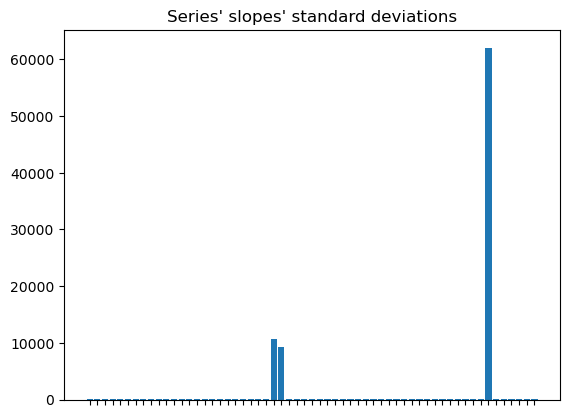

In [26]:
fig,ax = plt.subplots(1)
plt.bar(series_slopes.index, height=series_slopes['std'])
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
plt.title("Series' slopes' standard deviations")
ax.set_xticklabels([])
plt.show()
None

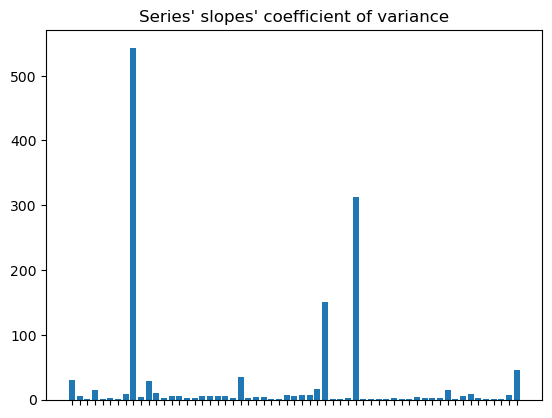

In [27]:
fig,ax = plt.subplots(1)
plt.bar(series_slopes.index, height=series_slopes['CoV'])
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
plt.title("Series' slopes' coefficient of variance")
ax.set_xticklabels([])
plt.show()
None

Renewable energy output % (EG.ELC.RNEW.ZS) appears to have the biggest CoV. Let's analyse it.

In [28]:
rnew_out = ESGData.xs('EG.ELC.RNEW.ZS',level=1)
rnew_out.count()[rnew_out.count() > 0].index

Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015],
           dtype='int64')

This stat was only recorded from 1990 to 2015.

In [29]:
rnew_out = rnew_out.loc[:,'1990':'2015']\
				   .T\
                   .rename_axis('Year')
rnew_out

Country Code,ARB,CSS,CEB,EAR,EAS,EAP,TEA,EMU,ECS,ECA,...,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
Year,,,,,,,,,,,,,,,,,,,,,
1990,7.241521,3.160282,6.960161,26.028589,15.783720,22.507119,21.284782,11.907666,16.100046,14.657445,...,1.828767,11.528647,94.948952,11.802929,0.000000,62.343858,61.847713,0.0,99.226257,46.667379
1991,6.690711,2.430221,8.255933,25.519341,15.068187,20.538155,19.391140,12.587799,16.356677,15.398985,...,1.656439,10.757414,87.904260,11.134496,0.000000,70.325402,68.588491,0.0,99.281530,35.320484
1992,5.769018,2.372794,7.575046,25.221915,14.040954,19.531725,18.519446,12.921670,17.297095,16.460846,...,2.005662,9.916110,89.762895,12.337216,0.000000,70.093416,74.477074,0.0,99.072525,38.375622
1993,5.387482,2.635238,8.305124,25.259809,14.609999,19.509535,18.635395,13.440532,18.342821,18.363619,...,1.777626,10.484326,92.228629,14.970803,0.000000,68.429852,74.704558,0.0,99.292510,27.611141
1994,5.320985,2.825307,9.060523,24.953713,13.355900,19.411476,18.596055,14.642590,18.989169,20.057030,...,2.139842,9.747236,98.792492,14.970711,0.000000,72.006852,75.219727,0.0,99.398034,27.803583
1995,5.081063,3.205473,9.995117,24.015440,14.285316,20.225122,19.462255,13.578256,18.902037,20.300534,...,2.066535,10.801085,93.546853,13.040271,0.000000,70.051466,72.241944,0.0,99.331146,29.253617
1996,5.300068,3.522179,9.760683,23.445283,13.380937,18.602630,17.972150,14.011743,17.851950,19.756203,...,1.627480,11.581450,87.091454,14.366234,0.000000,71.237498,70.868744,0.0,99.288207,29.537075
1997,5.171465,3.462857,9.868169,22.689282,13.140489,17.760961,17.253341,13.528125,18.309075,19.757746,...,1.989232,10.977828,91.172356,12.543970,0.000000,73.359380,60.929333,0.0,99.307392,29.090162
1998,4.809930,2.950569,10.767022,22.238268,13.512058,18.343567,17.862908,13.645960,18.857733,20.638722,...,2.395321,9.608585,96.122492,12.544662,0.000000,71.596499,51.157322,0.0,99.158227,29.257178


In [30]:
rnew_out_slopes = slopes.xs('EG.ELC.RNEW.ZS', level=1)

In [31]:
rnew_out_slopes.sort_values(ascending=False)

Country Code
LSO    5.230769
LIE    4.979036
SLE    3.566811
SUR    3.494554
MNE    3.241355
         ...   
HND   -2.138082
LKA   -2.347948
HTI   -2.579641
TZA   -2.671291
RWA   -3.144952
Length: 239, dtype: float64

## Series' yearly means

In [32]:
series_mean = ESGData.groupby("Series Code").mean()

In [33]:
mean_corr = series_mean.T.corr()

In [34]:
mean_corr

Series Code,AG.LND.AGRI.ZS,AG.LND.FRST.ZS,AG.PRD.FOOD.XD,CC.EST,EG.CFT.ACCS.ZS,EG.EGY.PRIM.PP.KD,EG.ELC.ACCS.ZS,EG.ELC.COAL.ZS,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,...,SL.TLF.ACTI.ZS,SL.TLF.CACT.FM.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SN.ITK.DEFC.ZS,SP.DYN.LE00.IN,SP.DYN.TFRT.IN,SP.POP.65UP.TO.ZS,SP.UWT.TFRT,VA.EST
Series Code,,,,,,,,,,,,,,,,,,,,,
AG.LND.AGRI.ZS,1.000000,-0.344478,0.892023,0.523783,-0.734119,-0.379733,-0.881765,-0.481663,-0.316379,-0.299087,...,-0.019655,0.452598,0.588857,-0.846006,0.646664,0.922735,-0.965880,0.898837,-0.219340,0.163280
AG.LND.FRST.ZS,-0.344478,1.000000,-0.925043,0.865056,-0.997511,0.955795,0.058473,0.348540,0.133792,0.948336,...,-0.162188,-0.952336,0.207618,0.900127,0.981181,-0.933984,0.931082,-0.935111,0.253925,0.552903
AG.PRD.FOOD.XD,0.892023,-0.925043,1.000000,-0.818435,0.993410,-0.979617,0.003025,-0.500043,0.112983,-0.966105,...,0.391252,0.971480,-0.353097,-0.923008,-0.981969,0.978693,-0.969490,0.993531,-0.209747,-0.468219
CC.EST,0.523783,0.865056,-0.818435,1.000000,-0.757198,0.825482,-0.746506,0.046865,-0.253538,0.849603,...,-0.472862,-0.859355,0.651704,0.098100,0.703869,-0.834932,0.856963,-0.779245,-0.086441,0.513776
EG.CFT.ACCS.ZS,-0.734119,-0.997511,0.993410,-0.757198,1.000000,-0.987460,0.974850,-0.550719,0.700387,-0.974836,...,0.746758,0.998174,-0.554203,-0.304987,-0.988413,0.993860,-0.996644,0.970711,0.193209,-0.308888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP.DYN.LE00.IN,0.922735,-0.933984,0.978693,-0.834932,0.993860,-0.986696,0.152758,-0.645087,0.089201,-0.974441,...,0.561270,0.978926,-0.489946,-0.872727,-0.956327,1.000000,-0.983671,0.963225,-0.182700,-0.296655
SP.DYN.TFRT.IN,-0.965880,0.931082,-0.969490,0.856963,-0.996644,0.962181,0.158256,0.563121,0.182333,0.929393,...,-0.400676,-0.990254,0.311837,0.908128,0.939194,-0.983671,1.000000,-0.962833,0.260589,0.357463
SP.POP.65UP.TO.ZS,0.898837,-0.935111,0.993531,-0.779245,0.970711,-0.988833,0.107660,-0.516593,0.023855,-0.961526,...,0.694986,0.972385,-0.553820,-0.854003,-0.860300,0.963225,-0.962833,1.000000,-0.099820,-0.057296


<Axes: xlabel='Series Code', ylabel='Series Code'>

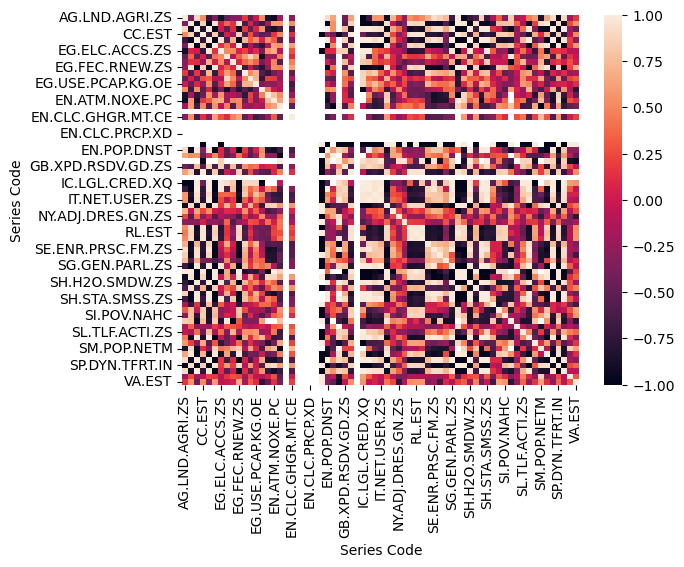

In [35]:
sns.heatmap(mean_corr)

In [36]:
corr_extremes = mean_corr.apply(lambda x: pd.Series({'min_id': x.drop(x.name).idxmin(),\
                                                     'min_corr': x.drop(x.name).min(),\
                                                     'max_id': x.drop(x.name).idxmax(),\
                                                     'max_corr': x.drop(x.name).max()}))\
                         .T

In [37]:
corr_extremes

,min_id,min_corr,max_id,max_corr
Series Code,,,,
AG.LND.AGRI.ZS,IC.LGL.CRED.XQ,-0.989388,SH.DTH.COMM.ZS,0.980556
AG.LND.FRST.ZS,IC.LGL.CRED.XQ,-0.998646,SH.DTH.COMM.ZS,0.999997
AG.PRD.FOOD.XD,SH.DTH.COMM.ZS,-0.998379,IP.JRN.ARTC.SC,0.996523
CC.EST,EN.MAM.THRD.NO,-1.0,SH.DTH.COMM.ZS,0.983174
EG.CFT.ACCS.ZS,SH.DTH.COMM.ZS,-0.999918,SL.TLF.CACT.FM.ZS,0.998174
...,...,...,...,...
SP.DYN.LE00.IN,EN.MAM.THRD.NO,-1.0,IP.JRN.ARTC.SC,0.997559
SP.DYN.TFRT.IN,EG.CFT.ACCS.ZS,-0.996644,EN.MAM.THRD.NO,1.0
SP.POP.65UP.TO.ZS,EN.MAM.THRD.NO,-1.0,IC.LGL.CRED.XQ,0.996771


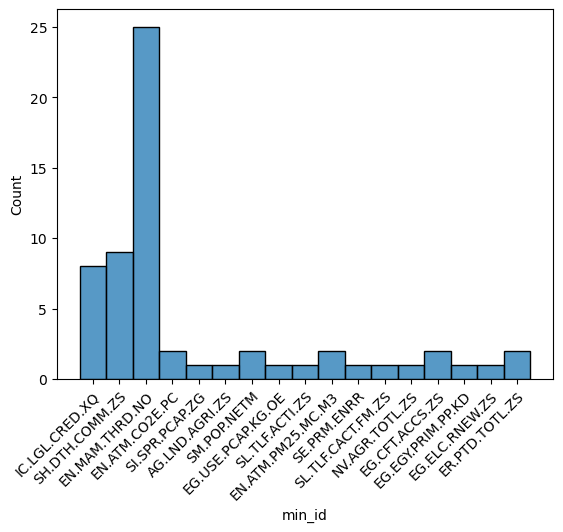

In [38]:
sns.histplot(corr_extremes['min_id'],cbar=True)
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
None

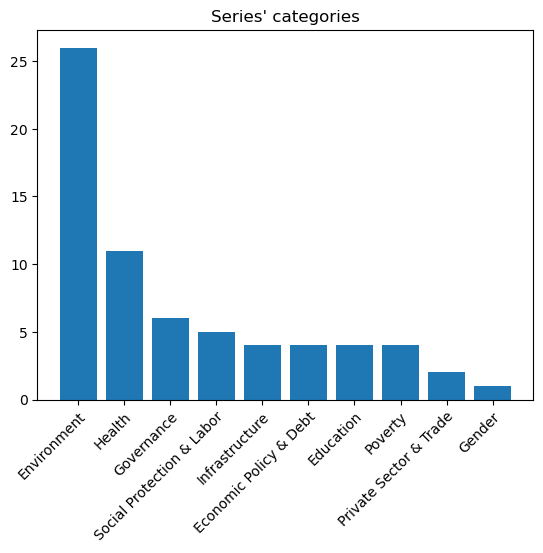

In [39]:
topics = data['ESGSeries']['Topic'].apply(lambda x: x.split(':')[0])
plt.bar(topics.value_counts().index, height=topics.value_counts())
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
plt.title("Series' categories")
None

## Income groups

C:\Users\noelp\AppData\Local\Temp\ipykernel_29032\3574833322.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


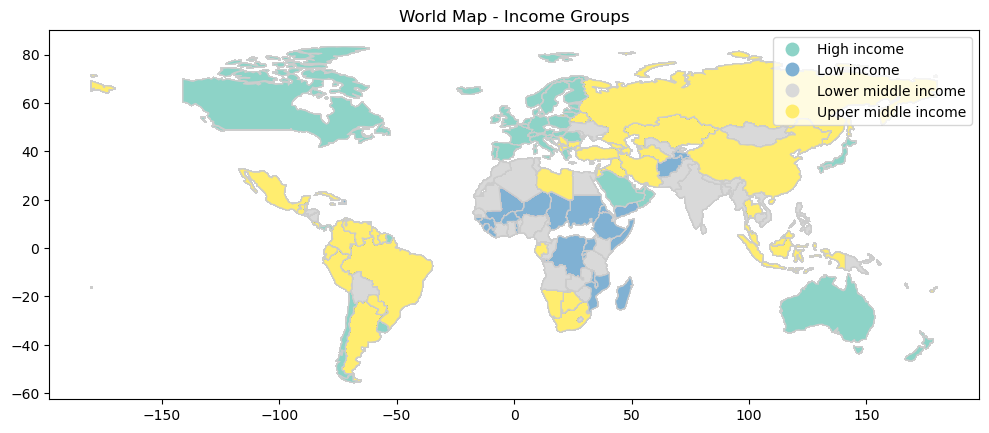

In [40]:
def world_map():
	merged_df = pd.merge(ESGCountry[['Short Name','Income Group']], ESGData, on='Country Code')

	merged_df_map = merged_df[['Income Group', 'Short Name']]

	world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

	merged_data = world.merge(merged_df_map, left_on='name', right_on='Short Name')


	fig, ax = plt.subplots(figsize=(12, 8))
	merged_data.plot(column='Income Group', cmap='Set3', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
	plt.title('World Map - Income Groups')

	plt.show()

world_map()

Countries per income group.

Text(0.5, 1.0, 'Country count per income group')

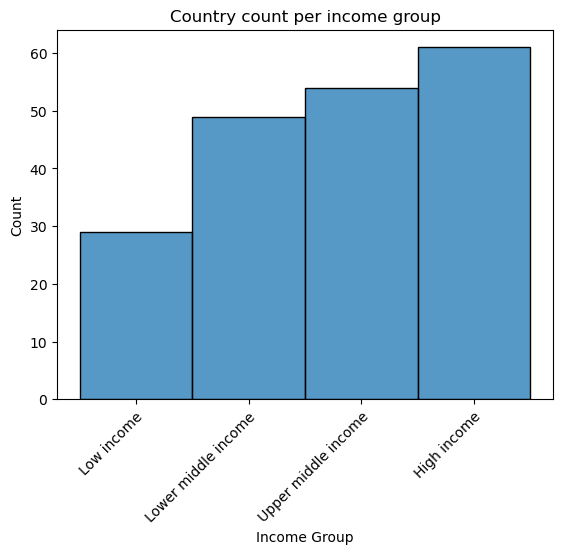

In [41]:
sns.histplot(ESGCountry['Income Group'])
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
plt.title("Country count per income group")
None

In [42]:
income_x_region = ESGCountry.groupby('Region')\
    						.value_counts(subset=['Income Group'], normalize=True)\
							.unstack(level='Income Group')
income_x_region[['High income','Upper middle income','Lower middle income','Low income']]

Income Group,High income,Upper middle income,Lower middle income,Low income
Region,,,,
East Asia & Pacific,0.266667,0.300000,0.400000,0.033333
Europe & Central Asia,0.634615,0.269231,0.076923,0.019231
Latin America & Caribbean,0.242424,0.606061,0.121212,0.030303
Middle East & North Africa,0.400000,0.250000,0.250000,0.100000
North America,1.000000,NaN,NaN,NaN
South Asia,NaN,0.125000,0.750000,0.125000
Sub-Saharan Africa,0.041667,0.104167,0.375000,0.479167


<Axes: xlabel='Income Group', ylabel='Region'>

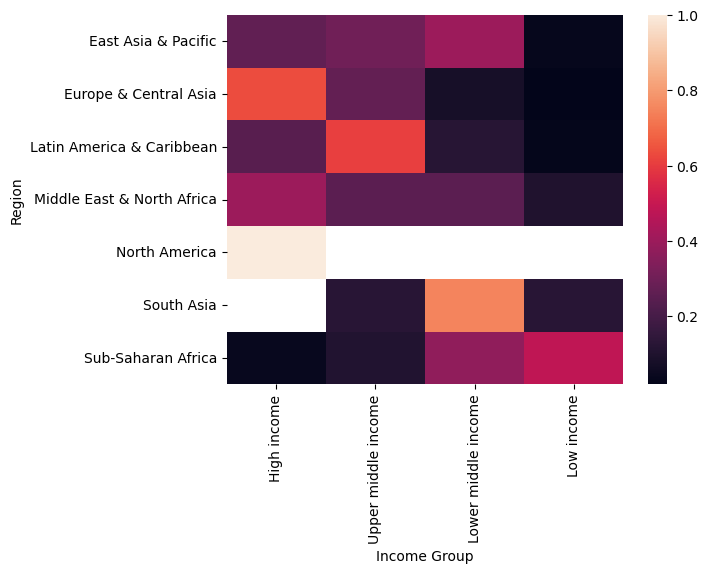

In [43]:
sns.heatmap(income_x_region[['High income','Upper middle income','Lower middle income','Low income']])

The fraction of countries without an income group:

In [44]:
unlabeled = ESGCountry[ESGCountry['Income Group'].isna()]
unlabeled.shape[0] / ESGCountry.shape[0]

0.19246861924686193

Fraction of unlabeled countries with data in ESGData

In [45]:
unlabeled.index.isin(ESGData.index.get_level_values('Country Code')).sum() / unlabeled.shape[0]

1.0

# Data completion

Data density:

In [46]:
ESGData.notna().sum().sum() / ESGData.size

0.3594972230224233

Set modeling variables

In [47]:
X = ESGData.stack().unstack(level=1).rename_axis(mapper=['Country Code','Year'], index=1)
ccodes = X.index.get_level_values('Country Code')
income_groups = pd.Series([ESGCountry.loc[code, 'Income Group'] for code in ccodes], index=ccodes)
# income_groups['LIC'] = 'Low income'
# income_groups['LMC'] = 'Lower middle income'
# income_groups['UMC'] = 'Upper middle income'
# income_groups['HIC'] = 'High income'
y = income_groups

Drop samples with missing income groups.

In [48]:
X_labeled = X[y.notna().values]
y = y.dropna()

Labeled data density:

In [49]:
X_labeled.notna().sum().sum() / X_labeled.size

0.3605508024729907

Data density per column:

In [50]:
(X_labeled.notna().sum() / X_labeled.shape[0]).describe()

count    67.000000
mean      0.360551
std       0.274123
min       0.007699
25%       0.120669
50%       0.334059
75%       0.494142
max       0.915649
dtype: float64

Interpolate to fill data where possible.

In [51]:
X_regress = X_labeled.unstack(level=0)\
                    .interpolate(axis=0, limit_direction='both')\
                    .stack()\
                    .reorder_levels(X.index.names)\
                    .sort_index(level=0)

Interpolated data density:

In [52]:
X_regress.count().sum() / X_regress.size

0.910525094733586

Some removed rows got regenerated by the interpolation.

In [53]:
X_regen = X_regress.loc[X_regress.index.drop(X_labeled.index)]
X_regen

Series Code        AG.LND.AGRI.ZS  AG.LND.FRST.ZS  AG.PRD.FOOD.XD    CC.EST  \
Country Code Year                                                             
AND          1960       55.319149       34.042553             NaN  1.318143   
LIE          1960       56.250000       40.625000           39.35  1.318143   
MCO          1960             NaN             NaN             NaN       NaN   
NRU          1960       15.000001        0.000000           40.12 -0.352820   
SMR          1960       16.666667        0.000000             NaN       NaN   
SRB          1960       40.441345       28.310085          100.00 -1.140072   
             1963       40.441345       28.310085          100.00 -1.140072   
             1964       40.441345       28.310085          100.00 -1.140072   
             1965       40.441345       28.310085          100.00 -1.140072   
             1966       40.441345       28.310085          100.00 -1.140072   
             1968       40.441345       28.310085          100.00 -1.140072   
             1969       40.441345       28.310085          100.00 -1.140072   
             1970       40.441345       28.310085          100.00 -1.140072   
             1973       40.441345       28.310085          100.00 -1.140072   
             1974       40.441345       28.310085          100.00 -1.140072   
TUV          1960       66.666667       33.333333           79.22  0.468868   

Series Code        EG.CFT.ACCS.ZS  EG.EGY.PRIM.PP.KD  EG.ELC.ACCS.ZS  \
Country Code Year                                                      
AND          1960          100.00                NaN      100.000000   
LIE          1960             NaN                NaN      100.000000   
MCO          1960          100.00                NaN      100.000000   
NRU          1960           73.90           4.365010       99.800000   
SMR          1960          100.00                NaN      100.000000   
SRB          1960           51.96           7.231833      100.000000   
             1963           51.96           7.231833      100.000000   
             1964           51.96           7.231833      100.000000   
             1965           51.96           7.231833      100.000000   
             1966           51.96           7.231833      100.000000   
             1968           51.96           7.231833      100.000000   
             1969           51.96           7.231833      100.000000   
             1970           51.96           7.231833      100.000000   
             1973           51.96           7.231833      100.000000   
             1974           51.96           7.231833      100.000000   
TUV          1960           18.63           3.450986       94.629783   

Series Code        EG.ELC.COAL.ZS  EG.ELC.RNEW.ZS  EG.FEC.RNEW.ZS  ...  \
Country Code Year                                                  ...   
AND          1960             NaN      100.000000       14.273550  ...   
LIE          1960             NaN        0.000000       54.475850  ...   
MCO          1960             NaN        0.000000             NaN  ...   
NRU          1960             NaN        0.000000        0.000000  ...   
SMR          1960             NaN        0.000000             NaN  ...   
SRB          1960       69.058318       23.129335       15.491653  ...   
             1963       69.058318       23.129335       15.491653  ...   
             1964       69.058318       23.129335       15.491653  ...   
             1965       69.058318       23.129335       15.491653  ...   
             1966       69.058318       23.129335       15.491653  ...   
             1968       69.058318       23.129335       15.491653  ...   
             1969       69.058318       23.129335       15.491653  ...   
             1970       69.058318       23.129335       15.491653  ...   
             1973       69.058318       23.129335       15.491653  ...   
             1974       69.058318       23.129335       15.491653  ...   
TUV          1960     

Remove them for now.

In [54]:
X_filtered = X_regress.drop(X_regen.index)

Filtered data density:

In [55]:
X_filtered.notna().sum().sum() / X_filtered.size

0.9106563417223505

Impute to fill the rest.

In [56]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

# imp = IterativeImputer(random_state=SEED)
imp = KNNImputer()
X_imp = imp.fit_transform(X_filtered)
X_imp = pd.DataFrame(X_imp, index=X_filtered.index, columns=X_filtered.columns)

Imputed data density:

In [57]:
X_imp.notna().sum().sum() / X_imp.size

1.0

Data completion finished.

In [58]:
X_filled = X_imp

Add extra features

In [59]:
# regions = pd.DataFrame(X_filled.index.get_level_values(0)).apply(lambda x: ESGCountry.loc[x, 'Region'])
# currency = pd.DataFrame(X_filled.index.get_level_values(0)).apply(lambda x: ESGCountry.loc[x, 'Currency Unit'])
# concepts = pd.DataFrame(X_filled.index.get_level_values(0)).apply(lambda x: ESGCountry.loc[x, 'Government Accounting concept'])
# lending = pd.DataFrame(X_filled.index.get_level_values(0)).apply(lambda x: ESGCountry.loc[x, 'Lending category'])

In [60]:
# from sklearn.preprocessing import OrdinalEncoder

# enc = OrdinalEncoder(encoded_missing_value=-1)
# X_filled['Region'] = enc.fit_transform(regions)
# X_filled['Currency Unit'] = enc.fit_transform(currency)
# X_filled['Government Accounting concept'] = enc.fit_transform(concepts)
# X_filled['Lending category'] = enc.fit_transform(lending)

# Modeling

In [61]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

model = {'HGB': HistGradientBoostingClassifier(verbose=1, random_state=SEED),
         'RF': RandomForestClassifier(verbose=1, random_state=SEED, n_jobs=-1),
         'SGD': SGDClassifier(n_jobs=-1, random_state=SEED)}
model['VC'] = VotingClassifier([('HGB',model['HGB']),('RF',model['RF'])], n_jobs=-1, voting='soft')

Cross-validate HistGradientBoostingClassifier using unfilled labeled data

In [62]:
cv = cross_validate(model['HGB'], X_labeled, y, n_jobs=-1)
pd.DataFrame(cv).describe()

,fit_time,score_time,test_score
count,5.000000,5.000000,5.000000
mean,34.115532,0.398337,0.705439
std,3.952294,0.083773,0.052570
min,27.049232,0.262299,0.621757
25%,35.750958,0.373999,0.692887
50%,35.762927,0.435837,0.717155
75%,35.962392,0.456779,0.738075
max,36.052153,0.462770,0.757322


Cross-validate HistGradientBoostingClassifier

In [63]:
cv2 = cross_validate(model['HGB'], X_filled, y, n_jobs=-1)
pd.DataFrame(cv2).describe()

,fit_time,score_time,test_score
count,5.000000,5.000000,5.000000
mean,20.446545,0.202852,0.731632
std,5.321192,0.052850,0.044374
min,10.937187,0.111665,0.683264
25%,22.487537,0.210439,0.691213
50%,22.797702,0.220413,0.746025
75%,22.853554,0.223401,0.747280
max,23.156745,0.248341,0.790377


Cross-validate RandomForestClassifier

In [64]:
cv3 = cross_validate(model['RF'], X_filled, y, n_jobs=-1)
pd.DataFrame(cv3).describe()

,fit_time,score_time,test_score
count,5.000000,5.000000,5.000000
mean,8.985607,0.321342,0.748201
std,3.563601,0.264726,0.062062
min,2.628969,0.123670,0.683682
25%,10.120728,0.200463,0.690795
50%,10.634362,0.215433,0.748117
75%,10.750047,0.283239,0.793305
max,10.793927,0.783905,0.825105


Cross-validate VotingClassifier

In [65]:
cv4 = cross_validate(model['VC'], X_filled, y, n_jobs=-1)
pd.DataFrame(cv4).describe()

,fit_time,score_time,test_score
count,5.000000,5.000000,5.000000
mean,25.349481,0.384582,0.739665
std,7.911216,0.144752,0.038290
min,11.219010,0.237359,0.702092
25%,28.377928,0.238363,0.707113
50%,28.519555,0.406912,0.739331
75%,29.301987,0.478250,0.753556
max,29.328924,0.562025,0.796234


Optimize parameters and cross-validate linear models through SGD

In [66]:
params = {'loss': ['hinge', 'log_loss', 'modified_huber'],
          'alpha': np.logspace(-4, 0, num=5)}
search = HalvingGridSearchCV(model['SGD'], param_grid=params,
                             n_jobs=-1, verbose=1, random_state=SEED)
fit = search.fit(X_filled, y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1327
max_resources_: 11950
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 1327
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 1
n_candidates: 5
n_resources: 3981
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 11943
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [67]:
results = pd.DataFrame(fit.cv_results_)
results[results['rank_test_score'] == 1]

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_loss,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,1,3981,0.237465,0.022185,0.00718,0.000747,0.01,modified_huber,"{'alpha': 0.01, 'loss': 'modified_huber'}",0.483668,...,0.455779,0.07056,1,0.433731,0.452575,0.497802,0.416457,0.47142,0.454397,0.028438
